# How to pre- and post- process data

Here below we present some functions that can be used to have more insights into both the inputs (e.g. number of trial sites) and outputs (e.g. distortions induced by the muon).

In [1]:
from aiida import orm,load_profile
load_profile()

import numpy as np

from aiida_muon.utils.sites_supercells import niche_add_impurities, gensup, compute_suggest_supercell_size

In [2]:
structure = orm.load_node(21259) # <- LiF

#### Hint on the supercell size

In [3]:
# suggest supercell size
suggested_size = compute_suggest_supercell_size(structure.get_ase())
print(f"Suggested supercell size: {suggested_size}")
print(f"Ready to be used in FindMuonWorkChain: {[[suggested_size[0], 0,0], [0, suggested_size[1], 0], [0, 0, suggested_size[2]]]}")

Suggested supercell size: [3, 3, 3]
Ready to be used in FindMuonWorkChain: [[3, 0, 0], [0, 3, 0], [0, 0, 3]]


#### Estimation of the number of muon trial sites

In [4]:
# number of trial sites for a given mu_spacing
mu_spacing = 1
mu_list = niche_add_impurities(
    structure.get_pymatgen_structure(),
    niche_atom = "H",
    niche_spacing = mu_spacing,
    niche_distance = 1, # distance from hosting atoms,
)

print(f"Number of trial sites for mu_spacing={mu_spacing} Angstrom: \n{len(mu_list)}")

Number of trial sites for mu_spacing=1 Angstrom: 
4


#### Generation of the supercell with the impurity

In [5]:
# generate the supercell structures with the muon inside

# 1 get sc_matrix
suggested_size = compute_suggest_supercell_size(structure.get_ase())
sc_matrix = [[suggested_size[0], 0,0], [0, suggested_size[1], 0], [0, 0, suggested_size[2]]]

# 2 get the muon list
mu_spacing = 1
mu_list = niche_add_impurities(
    structure.get_pymatgen_structure(),
    niche_atom = "H",
    niche_spacing = mu_spacing,
    niche_distance = 1, # distance from hosting atoms,
)

# 3 produce the supercells
supc_list = gensup(structure.get_pymatgen_structure(), mu_list, sc_matrix)

assert len(supc_list) == len(mu_list)
print(f"Supercell matrix: {sc_matrix}")
print(f"Muon spacing: {mu_spacing}")
print(f"Supercells (or equivalently, number of candidate muon sites): {len(supc_list)}")

Supercell matrix: [[3, 0, 0], [0, 3, 0], [0, 0, 3]]
Muon spacing: 1
Supercells (or equivalently, number of candidate muon sites): 4


#### Generating an undistorted supercell with all the muon inside

In [6]:
# generate all the sites in one unit cell. Useful for visualizing data before submission.

# 1 get sc_matrix
suggested_size = compute_suggest_supercell_size(structure.get_ase())
sc_matrix = [[suggested_size[0], 0,0], [0, suggested_size[1], 0], [0, 0, suggested_size[2]]]
## 1.1 actually, for visualization purposes, we can use the unit cell
sc_matrix = [[1, 0,0], [0, 1, 0], [0, 0, 1]]


# 2 get the muon list
mu_spacing = 1
mu_list = niche_add_impurities(
    structure.get_pymatgen_structure(),
    niche_atom = "H",
    niche_spacing = mu_spacing,
    niche_distance = 1, # distance from hosting atoms,
)

# 3 produce the supercells
supc_list = gensup(structure.get_pymatgen_structure(), mu_list, sc_matrix, only_one_cell=True)

print(f"Supercell with all sites: \n{supc_list[0]}")
# check the results in VESTA, openening the file in 

Supercell with all sites: 
Full Formula (Li4 H4 F4)
Reduced Formula: LiHF
abc   :   4.083428   4.083428   4.083428
angles:  90.000000  90.000000  90.000000
pbc   :       True       True       True
Sites (12)
  #  SP        a      b      c  kind_name
---  ----  -----  -----  -----  -----------
  0  Li    0      0      0
  1  F     0      0.5    0
  2  Li    0      0.5    0.5
  3  F     0      0      0.5
  4  Li    0.5    0      0.5
  5  F     0.5    0.5    0.5
  6  Li    0.5    0.5    0
  7  F     0.5    0      0
  8  H     0.201  0.001  0.201  H
  9  H     0.201  0.201  0.201  H
 10  H     0.201  0.201  0.401  H
 11  H     0.401  0.201  0.401  H


In [7]:
print(supc_list[0].to(fmt="cif"))

# generated using pymatgen
data_LiHF
_symmetry_space_group_name_H-M   'P 1'
_cell_length_a   4.08342800
_cell_length_b   4.08342800
_cell_length_c   4.08342800
_cell_angle_alpha   90.00000000
_cell_angle_beta   90.00000000
_cell_angle_gamma   90.00000000
_symmetry_Int_Tables_number   1
_chemical_formula_structural   LiHF
_chemical_formula_sum   'Li4 H4 F4'
_cell_volume   68.08864750
_cell_formula_units_Z   4
loop_
 _symmetry_equiv_pos_site_id
 _symmetry_equiv_pos_as_xyz
  1  'x, y, z'
loop_
 _atom_site_type_symbol
 _atom_site_label
 _atom_site_symmetry_multiplicity
 _atom_site_fract_x
 _atom_site_fract_y
 _atom_site_fract_z
 _atom_site_occupancy
  Li  Li0  1  0.00000000  0.00000000  0.00000000  1.0
  F  F1  1  0.00000000  0.50000000  0.00000000  1.0
  Li  Li2  1  0.00000000  0.50000000  0.50000000  1.0
  F  F3  1  0.00000000  0.00000000  0.50000000  1.0
  Li  Li4  1  0.50000000  0.00000000  0.50000000  1.0
  F  F5  1  0.50000000  0.50000000  0.50000000  1.0
  Li  Li6  1  0.50000000  0.

#### Exporting the results of a FindMuonWorkChain

In [8]:
# clustering of the sites after the relaxation

# get the list of calculations performed by the FindMuonWorkChain
from aiida_muon.utils.export_findmuon import export_findmuon_data

findmuon = orm.load_node(26243)

In [9]:
exported = export_findmuon_data(findmuon.outputs)
exported.keys()

dict_keys(['table', 'table_all', 'distortions', 'unit_cell', 'unit_cell_all'])

In [10]:
exported['table']

,structure_id_pk,label,delta_E,tot_energy,muon_position_cc,muon_index_global_unitcell,muon_index
1,26303,A,0,-27606892.0,"[0.124, 0.0, 0.124]",9,1
3,26313,B,1,-27606890.5,"[0.12, 0.12, 0.248]",11,3
4,26308,C,331,-27606560.5,"[0.175, 0.146, 0.175]",12,4
2,26298,D,707,-27606184.7,"[0.095, 0.095, 0.095]",10,2


In [11]:
exported['table_all']

,structure_id_pk,label,delta_E,tot_energy
1,26303,A,0,-27606892.0
3,26313,B,1,-27606890.5
4,26308,C,331,-27606560.5
2,26298,D,707,-27606184.7


#### Dipolar field calculation

In [12]:
# dipolar fields

from aiida_muon.utils.magnetism import compute_dip_field

input_structure = findmuon.inputs.structure.get_pymatgen_structure()
relaxed_supercell = orm.load_node(28674).get_pymatgen_structure()

# NOTE: the magmoms here are just fake, you should provide the actual magnetic moments if any
magmom = [0.0 for _ in range(len(input_structure.sites))] # or findmuon input magmom
for i in range(len(input_structure.sites)):
    if input_structure.sites[i].species_string == "F":
        magmom[i] = 2.2
sc_mat = [[1, 0,0], [0, 1, 0], [0, 0, 1]]
cnt_field = 1 #  put one to just compute the dipolar field

compute_dip_field(input_structure, magmom, sc_mat, relaxed_supercell, cnt_field)

(array([-3.75968269e+00, -1.04548930e-05,  1.69562645e+00]),
 array([-3.75968269e+00, -1.04548930e-05,  2.69562645e+00]),
 4.626188051565715)

#### Obtain the distortion induce by the muons

In [13]:
# distortions

relaxed_supercell = orm.load_node(exported['table']["structure_id_pk"].values[0])
unrelaxed_supercell = relaxed_supercell.creator.caller.caller.inputs.structure.get_ase()
relaxed_supercell = relaxed_supercell.get_ase()

from aiida_muon.utils.export_findmuon import get_distortions

distortions = get_distortions(unrelaxed_supercell, relaxed_supercell)

In [14]:
for element, distortion in distortions.items():
    print(f"Element: {element}")
    print(f'Distance from the muon (unrelaxed): {distortion["atm_distance_init"]}\nDistortion: {distortion["distortion"]}\n')
    print(f'Distance from the muon (relaxed): {distortion["atm_distance_final"]}\n')

Element: Li
Distance from the muon (unrelaxed): [1.16074987 1.72668177 2.51322637 2.51322637 2.51985229 2.51985229
 3.11199813 3.11199813 3.36431598 3.36431598 3.60824185 3.60824185
 3.61286009 3.61286009 4.03578847 4.03578847 4.03991798 4.03991798
 4.04816438 4.24127053 4.42972521 4.61409838 4.7948609  4.7948609
 4.79833719 4.79833719 5.13084475 5.13084475 5.28768924 5.28768924
 5.74705754 6.15880989]
Distortion: [ 0.69083683  0.12845282  0.06449042  0.06449042  0.05975311  0.05975311
  0.20233626  0.20233626 -0.04584143 -0.04584143  0.24390798  0.24390798
  0.24099464  0.24099464 -0.17306839 -0.17306839 -0.17564059 -0.17564059
  0.37820042  0.09818247 -0.08530955 -0.18373426 -0.00741676 -0.00741676
 -0.00987795 -0.00987795  0.07715668  0.07715668 -0.07659113 -0.07659113
  0.21179347 -0.18723756]

Distance from the muon (relaxed): [1.8515867  1.85513459 2.57771679 2.57771679 2.57960539 2.57960539
 3.3143344  3.3143344  3.31847455 3.31847455 3.85214983 3.85214983
 3.85385472 3.85385472

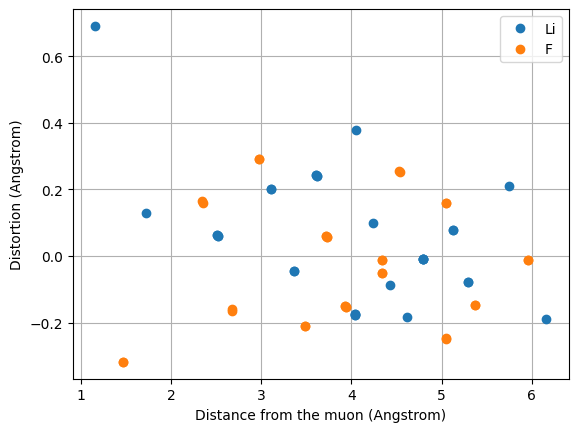

In [15]:
import matplotlib.pyplot as plt

fig,ax = plt.subplots()

for element, distortion in distortions.items():
    ax.plot(distortion["atm_distance_init"],distortion["distortion"], 'o', label=element)


ax.set_xlabel("Distance from the muon (Angstrom)")
ax.set_ylabel("Distortion (Angstrom)")

plt.legend()
plt.grid()